# Pipeline Debug Mode (Experimental)

## Overview

Debug mode is currently an experimental feature.

When you use DALI pipeline, you have to define the graph of operations ahead of time. In each iteration, the graph of operators is executed in the backend - and the user does not have access to the intermediate state, only to the pipeline outputs. This allows for better performance, but makes it harder to experiment and debug the pipeline. Debug mode allows you to access data as it's being processed in the graph. In debug mode graph's symbolic `DataNode` becomes `DataNodeDebug` that contains the underlying data.

## Defining debug pipeline

To use debug mode:

1. Change the standard version of `nvidia.dali.pipeline_def` to its experimental equivalent `nvidia.dali.pipeline.experimental.pipeline_def`

2. Define pipeline with parameter `debug=True`


In [2]:
import nvidia.dali.fn as fn
from nvidia.dali.pipeline.experimental import pipeline_def

image_dir = "../data/images"
max_batch_size = 8

@pipeline_def(batch_size=max_batch_size, num_threads=1, device_id=0, debug=True)
def simple_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True, initial_fill=21)
    images = fn.decoders.image(jpegs, device='cpu')
    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)

    return rotated_images, labels

The basic use of debug mode is to print objects returned by operators. It gives you much of the information you might want to check. 

In [3]:
@pipeline_def(batch_size=max_batch_size, num_threads=1, device_id=0)
def simple_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device='cpu')

    print(images)

    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)

    return rotated_images, labels


pipe = simple_pipeline(debug=True)
pipe.build()
pipe_out = pipe.run()


DataNodeDebug(
    name="__Image_2",
    data=TensorListCPU(
             [[[[124 113 119]
               [133 122 128]
               ...
               [224 190 215]
               [224 190 215]]

              [[106  95 103]
               [117 106 114]
               ...
               [226 192 217]
               [225 191 216]]

              ...

              [[186 134  94]
               [191 139  99]
               ...
               [158  98  62]
               [157  97  61]]

              [[192 140 100]
               [197 145 105]
               ...
               [159  99  63]
               [159  99  63]]]


             [[[202 172 162]
               [202 172 162]
               ...
               [ 19  15  16]
               [ 19  15  16]]

              [[203 173 163]
               [202 172 162]
               ...
               [ 19  15  16]
               [ 19  15  16]]

              ...

              [[193 149 124]
               [192 148 123]
               ...

Using it this way allows you to easily swap between standard and debug mode.

In [4]:
pipe_standard = simple_pipeline()
pipe_standard.build()
pipe_out = pipe_standard.run()

DataNode(name="__Image_6", device="cpu")


## Additional features

Debug mode provides some additional features for data manipulation.

### Data access

You can access the underlying data directly by calling `.get()` on DataNodeDebugs returned by operators.

In [5]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (max_batch_size + 1) // (columns)
    plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

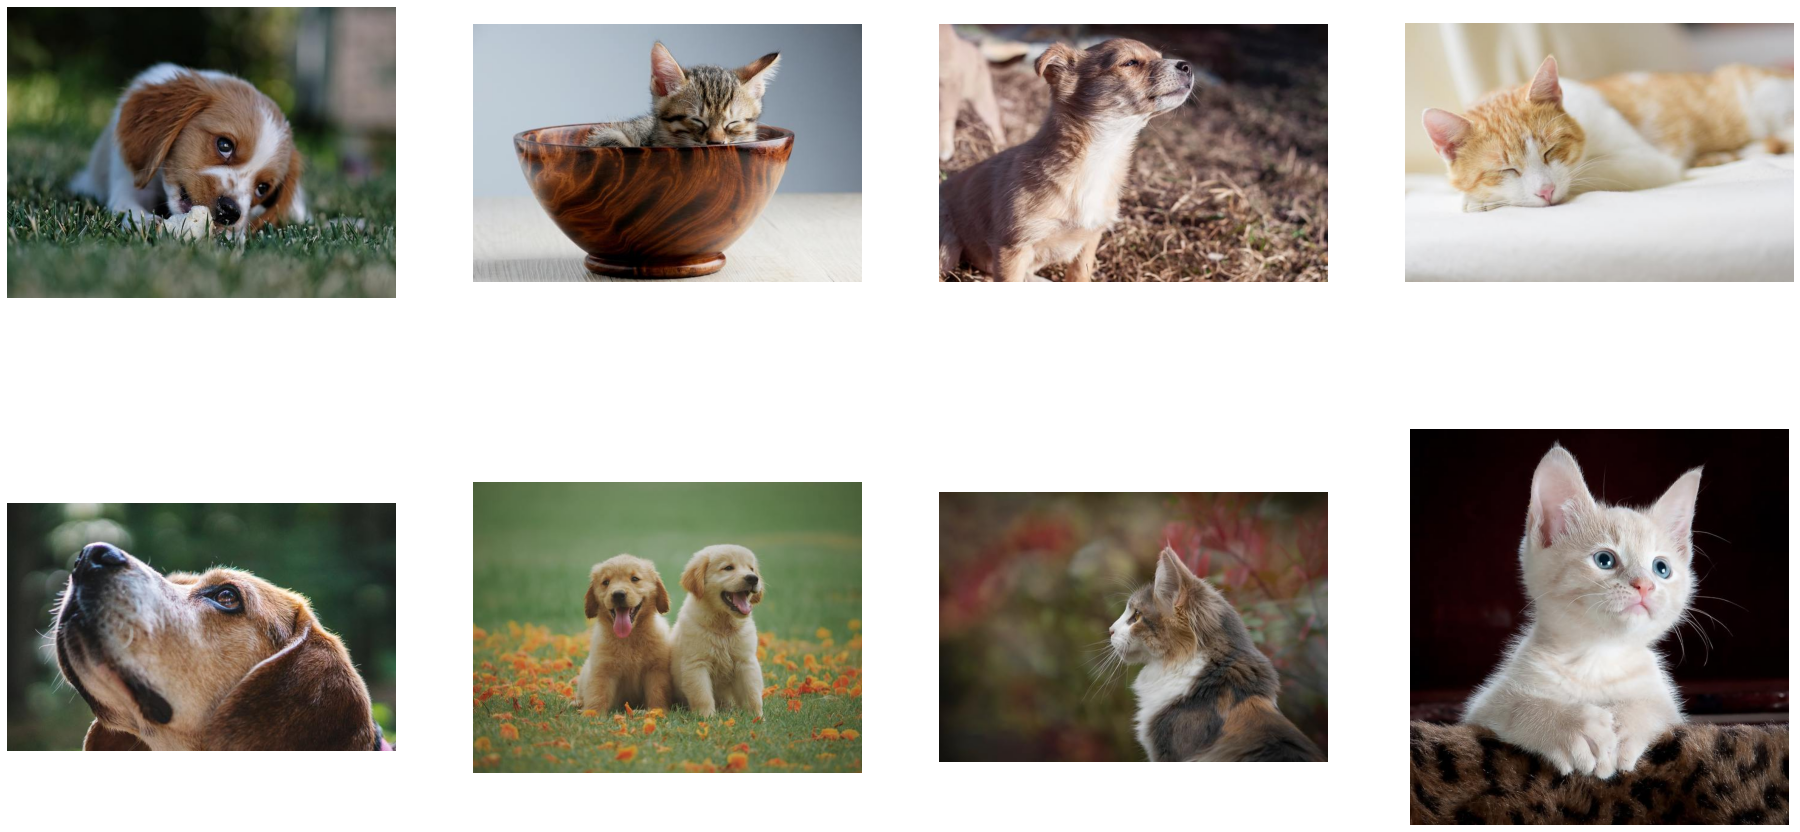

In [6]:
@pipeline_def(batch_size=8, num_threads=1, device_id=0, debug=True)
def simple_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device='cpu')

    show_images(images.get())

    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)

    return rotated_images, labels


pipe = simple_pipeline(debug=True)
pipe.build()
pipe_out = pipe.run()

You can check shape of the data.

In [7]:
@pipeline_def(batch_size=8, num_threads=1, device_id=0, debug=True)
def simple_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device='cpu')

    print(images.shape())

    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)

    return rotated_images, labels


pipe = simple_pipeline(debug=True)
pipe.build()
pipe_out = pipe.run()

[(480, 640, 3), (427, 640, 3), (427, 640, 3), (485, 640, 3), (427, 640, 3), (425, 640, 3), (427, 640, 3), (409, 640, 3)]


### Data modification

You can modify the data and pass it directly to the operator.

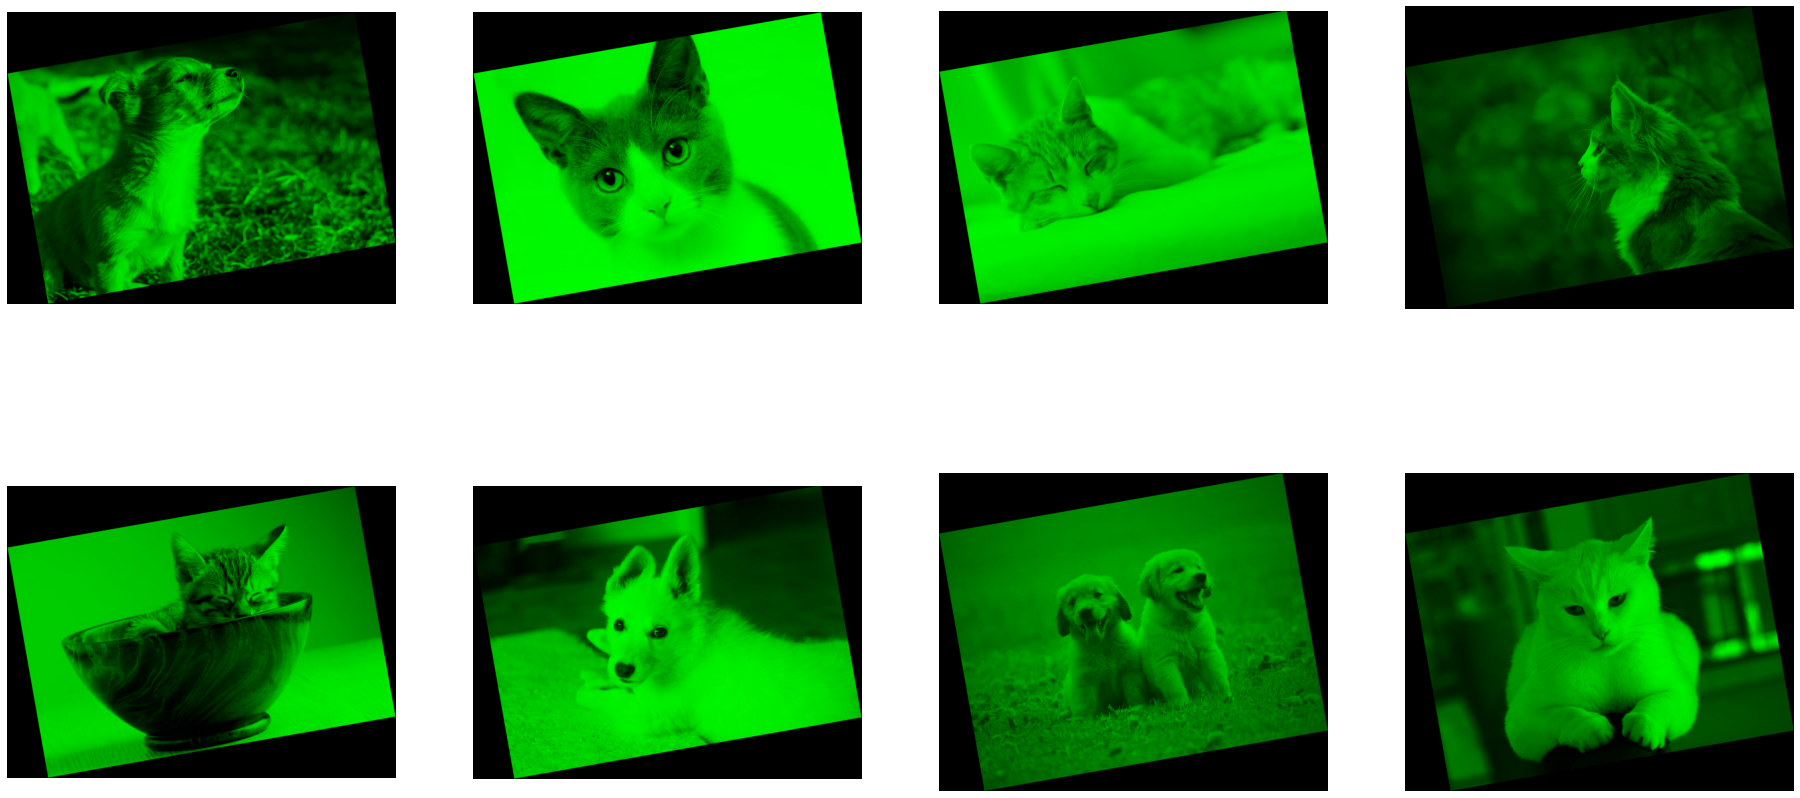

In [9]:
import numpy as np

@pipeline_def(batch_size=8, num_threads=1, device_id=0, debug=True)
def simple_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device='cpu')

    images = [np.array(tensor) for tensor in images.get()]
    for image in images:
        image[:, :, [0, 2]] = 0

    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)
    show_images(rotated_images.get())
    
    return rotated_images, labels

pipe = simple_pipeline(debug=True)
pipe.build()
pipe_out = pipe.run()